### xwavelet: an Xarray Front-end for Performing Wavelet Transforms

This package uses the original Python transform code by Torrence and Compo (1998).

In [1]:
%matplotlib inline

import xwavelet as xw
import xarray as xr
import matplotlib.pyplot as plt

Load an xarray timeseries data array of sea surface temperature and generate the area mean time series.

In [2]:
dset = xr.open_dataset(
    "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc",
    use_cftime=True,chunks={"time":2000}
)

dset = dset.sel(time=slice("1854-01-01","2019-12-31"))

# select NINO3 region
sst = dset.sst
sst = sst.sel(lat=slice(5, -5))
sst = sst.sel(lon=slice(210, 270))

# create area mean
sst = sst.mean(dim=("lat", "lon"))

In [3]:
dset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 1992, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) object 1854-01-01 00:00:00 ... 2019-12-01 00:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(1992, 2), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(1992, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-06-07
    DODS_EXTRA.Unlimited_Dimension:  time

Use the wavelet analysis with the default settings.  Defaults are for the "Morlet" transform and a starting timescale of 6 months. The result is an Xarray dataset.

In [4]:
result = xw.wavelet(sst)
print(result)

<xarray.Dataset>
Dimensions:             (time: 1992, period: 29)
Coordinates:
  * time                (time) object 1854-01-01 00:00:00 ... 2019-12-01 00:0...
  * period              (period) float64 0.5 0.5946 0.7071 ... 45.25 53.82 64.0
Data variables:
    wavelet             (period, time) complex128 (-0.5898456119480611-0.0533...
    cone_of_influence   (time) float64 6.087e-07 0.0 ... 0.06087 6.087e-07
    timeseries          (time) float64 0.185 0.8356 1.513 ... -0.4634 -0.4096
    spectrum            (period) float64 0.4529 0.2712 1.297 ... 1.253 1.245
    scaled_ts_variance  (time) float64 0.1825 0.1935 0.2049 ... 0.3327 0.3222
Attributes:
    dt:              0.08333333333333333
    pad:             1
    dj:              0.25
    pow2:            7
    s0:              0.5
    mother:          MORLET
    scaled:          False
    detrend:         True
    frequency_band:  (2, 8)


Plot the time-mean power spectrum

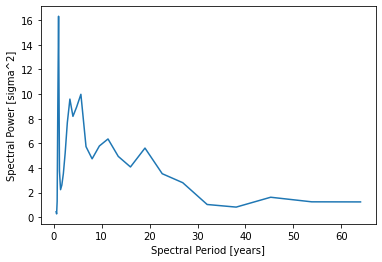

In [5]:
result.spectrum.plot()

### The Wavelet class

This package includes a super-class that both performs the wavelet transform and provides some methods for generating plots

In [6]:
result = xw.Wavelet(sst, scaled=True)
print(result)

In [7]:
print(result.dset)

<xarray.Dataset>
Dimensions:             (time: 1992, period: 29)
Coordinates:
  * time                (time) object 1854-01-01 00:00:00 ... 2019-12-01 00:0...
  * period              (period) float64 0.5 0.5946 0.7071 ... 45.25 53.82 64.0
Data variables:
    wavelet             (period, time) complex128 (-0.2733580495754494-0.0247...
    cone_of_influence   (time) float64 6.087e-07 0.0 ... 0.06087 6.087e-07
    timeseries          (time) float64 0.185 0.8356 1.513 ... -0.4634 -0.4096
    spectrum            (period) float64 0.09727 0.04898 ... 0.0025 0.00209
    scaled_ts_variance  (time) float64 0.1825 0.1935 0.2049 ... 0.3327 0.3222
Attributes:
    dt:              0.08333333333333333
    pad:             1
    dj:              0.25
    pow2:            7
    s0:              0.5
    mother:          MORLET
    scaled:          True
    detrend:         True
    frequency_band:  (2, 8)


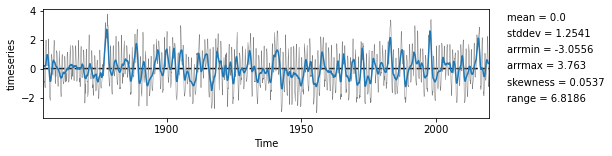

In [8]:
result.timeseries()

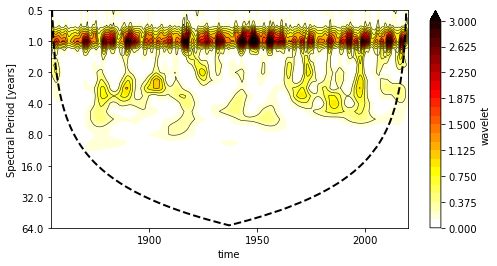

In [9]:
result.density()

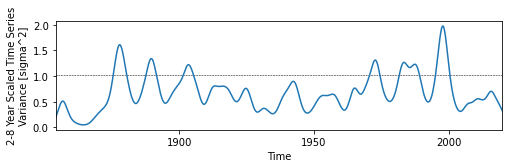

In [10]:
result.variance()

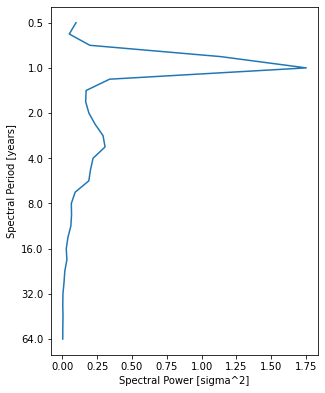

In [11]:
result.spectrum()

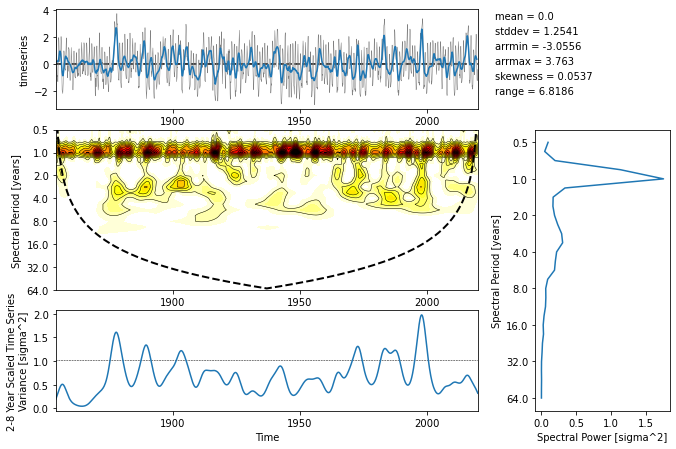

In [12]:
fig = result.composite()

## Frequency Filtering

In this example we will bandpass filter the SST timeseries between 4 and 8 years and verify the performance visually with the wavelet transform

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
sst_lowpass = xw.frequency_filter(sst,"10Y",btype="lowpass",iirf_format="sos")
sst_bandpass = xw.frequency_filter(sst,["4Y","8Y"],btype="bandpass",iirf_format="sos")
sst_highpass = xw.frequency_filter(sst,"2Y",btype="highpass",iirf_format="sos")

/Users/krasting/PycharmProjects/xwavelet/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")
/Users/krasting/PycharmProjects/xwavelet/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")
/Users/krasting/PycharmProjects/xwavelet/xwavelet/filtering.py:139: UserWarning: Irregular sampling frequency detected - using an average value.
  warnings.warn("Irregular sampling frequency detected - using an average value.")


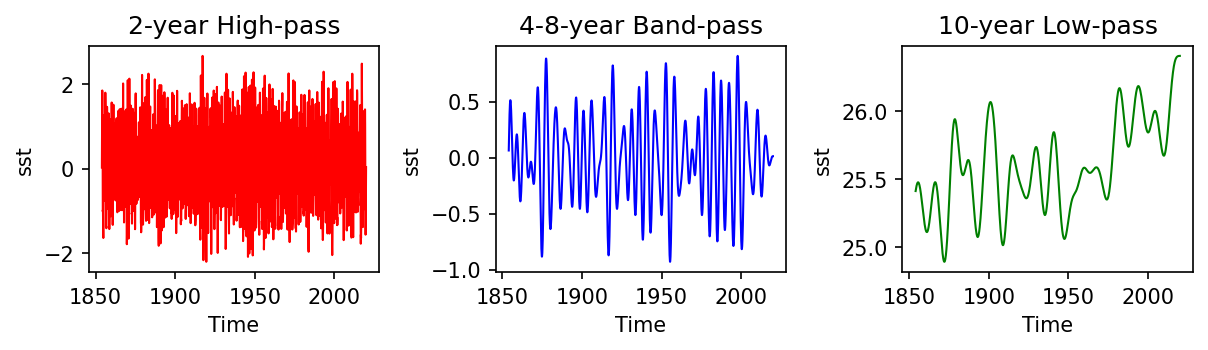

In [15]:
fig = plt.figure(figsize=(9.5,2),dpi=150)
ax = plt.subplot(1,3,1)
#sst.plot(color="gray",linewidth=0.5,ax=ax,alpha=0.4)
sst_highpass.plot(color="red",linewidth=1.0,ax=ax)
ax.set_title("2-year High-pass")

ax = plt.subplot(1,3,2)
#sst.plot(color="gray",linewidth=0.5,ax=ax,alpha=0.4)
sst_bandpass.plot(color="blue",linewidth=1.0,ax=ax)
ax.set_title("4-8-year Band-pass")

ax = plt.subplot(1,3,3)
#sst.plot(color="gray",linewidth=0.5,ax=ax,alpha=0.4)
sst_lowpass.plot(color="green",linewidth=1.0,ax=ax)
ax.set_title("10-year Low-pass")

plt.subplots_adjust(wspace=0.4)

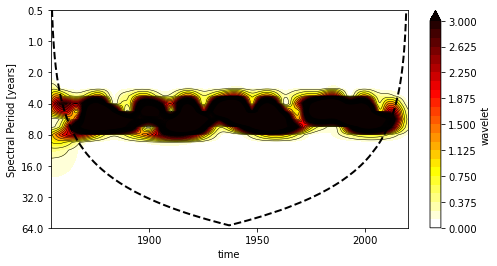

In [16]:
xw.Wavelet(sst_bandpass).density()